In [1]:
import torch
import torchvision
import os
import pandas as pd
from skimage import io
from fastprogress import master_bar, progress_bar
import numpy as np
from sklearn.metrics import roc_auc_score
from skimage.transform import resize
import sys

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__, DEVICE


('1.10.0', 'cuda')

In [2]:
from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep
mb = master_bar(range(10))
for i in mb:
    for j in progress_bar(range(100), parent=mb):
        sleep(0.01)
        mb.child.comment = f'second bar stat'
    mb.main_bar.comment = f'first bar stat'
    mb.write(f'Finished loop {i}.')
    #mb.update_graph(graphs, x_bounds, y_bounds)

In [3]:
torch.randn(2, device=DEVICE)

tensor([0.7212, 0.5555], device='cuda:0')

In [4]:
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
__pyTorch VERSION: 1.10.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:32:27_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.2, V10.2.89
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [5]:
PATH = 'data'
os.listdir(PATH)

['all.txt', 'PATCHES']

In [6]:
data = pd.read_csv(f'{PATH}/all.txt', sep=" ", header=None)
data[0] = "data/PATCHES/" + data[0]
data[:1].head()

,0,1
0,data/PATCHES/RAINY/2016-02-12/camera7/R_2016-0...,1


In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, train=True):
        self.images = images
        self.labels = labels
        self.train = train

    def __len__(self):
        return len(self.images)

    def load_img(self, img):
        return resize(io.imread(img), (150, 150, 3))

    def __getitem__(self, ix):
        img = self.load_img(self.images[ix])
        if self.train:
            return torch.from_numpy(img), torch.tensor([self.labels[ix]]).float()
        return torch.from_numpy(img)

In [8]:
train = data

In [9]:
train[0][:2]

0    data/PATCHES/RAINY/2016-02-12/camera7/R_2016-0...
1    data/PATCHES/SUNNY/2016-01-15/camera7/S_2016-0...
Name: 0, dtype: object

In [21]:
dataset = {
    'train': Dataset(train[0][:10000], train[1][:10000]),
}

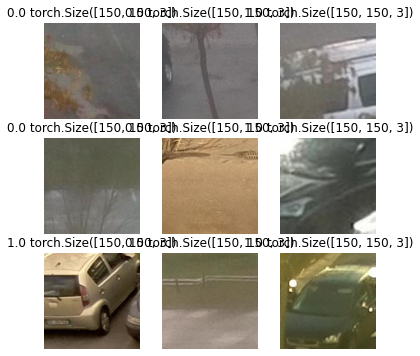

In [11]:
import matplotlib.pyplot as plt
import random

r, c = 3, 3
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['train'])-1)
        img, label = dataset['train'][ix]
        plt.imshow(img)
        plt.title(f"{label.item()} {img.shape}")
        plt.axis(False)
plt.show()

In [12]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torchvision.models.resnet50(pretrained=True)
        # freeze
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.encoder.fc = torch.nn.Linear(2048, 1)

    def forward(self, x):
        B, H, W, C = x.shape
        x = (x / 255.).float().view(B, C, H, W)
        x = self.encoder(x)
        return x

In [22]:
BATCH_SIZE = 64

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True, pin_memory=True),
}

In [14]:
imgs, labels = next(iter(dataloader['train']))

imgs.shape, labels.shape

(torch.Size([64, 150, 150, 3]), torch.Size([64, 1]))

In [15]:
def AUC(outputs, labels):
    outputs = torch.sigmoid(outputs)
    outputs = outputs.numpy()
    labels = labels.numpy()
    auc = roc_auc_score(labels, outputs)
    return auc

In [16]:
DEVICE

'cuda'

In [17]:
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', torch.cuda_version)
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
__pyTorch VERSION: 1.10.0
__CUDA VERSION 10.2
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:32:27_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.2, V10.2.89
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [23]:
net = Net()
net.to(DEVICE)

optimizer = torch.optim.Adam(net.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

EPOCHS = 20
validation_steps = 10
mb = master_bar(range(1, EPOCHS+1))
best_auc = 0
for epoch in mb:
    train_loss = []
    net.train()
    for batch in progress_bar(dataloader['train'], parent=mb):
        imgs, labels = batch
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = net(imgs)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        mb.child.comment = f'loss {np.mean(train_loss):.5f}'

    #print(f'Epoch {epoch}/{EPOCHS} loss {np.mean(train_loss):.5f}')
    mb.write(f'Epoch {epoch}/{EPOCHS} loss {np.mean(train_loss):.5f}') #val_loss {np.mean(val_loss):.5f} val_auc {auc:.5f}')

In [ ]:
"""
    val_loss = []
    net.eval()
    validation_step = 0
    val_outputs = torch.tensor([])
    val_targets = torch.tensor([])
    with torch.no_grad():
        for batch in progress_bar(dataloader['val'], parent=mb):
            imgs, labels = batch
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())
            mb.child.comment = f'val_loss {np.mean(val_loss):.5f}'
            val_outputs = torch.cat([val_outputs, outputs.cpu()])
            val_targets = torch.cat([val_targets, labels.cpu()])
            validation_step += 1
            if validation_step > validation_steps:
                break
    auc = AUC(val_outputs, val_targets)
    if auc > best_auc:
        best_auc = auc
        torch.save(net, 'model.pth')
        print(f"Best model ! {auc:.5f}")
    """